### 3.  Preprocessing & Modelling

The goal here is to use the datasets provided to build a model that predicts the presence of the West Nile Virus. The model is meant for use by the City of Chicago for decisions involving pesticide spray.

### Contents:
- [Import Libraries](#Import-Libraries)
- [Import Data](#Import-Data)
- [Data prepared for Modelling](#Data-prepared-for-Modelling)
- [Modelling](#Modelling)
- [Models Evaluation & Next Steps](#Models-Evaluation-&-Next-Steps)

### Import Libraries

We import the necessary libraries used in analysis.

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

### Import Data

We import the datasets with standardised file paths. 

In [2]:
# file paths

input_path = '../data/2_input/'
clean_path = '../data/3_clean/'
output_path = '../data/4_output/'

image_path = '../images/'

The datasets imported here have already been cleaned for null values. 

In [3]:
# import clean data

df_train = pd.read_csv(clean_path + 'train_clean.csv')
df_test = pd.read_csv(clean_path + 'test_clean.csv')
df_weather = pd.read_csv(clean_path + 'weather_clean.csv')

In [4]:
print('Size of train dataset: {}'.format(df_train.shape))
print('Size of test dataset: {}'.format(df_test.shape))
print('Size of weather dataset: {}'.format(df_weather.shape))

Size of train dataset: (8475, 11)
Size of test dataset: (116293, 10)
Size of weather dataset: (2944, 20)


### Data prepared for Modelling

We combine train and test data to prepare the datasets for modelling.

In [5]:
#Drops id column from test not in train
test = df_test.drop('id', axis=1)
#Drops nummosquitos and wnvpresent columns from train not in test
train = df_train.drop(['nummosquitos', 'wnvpresent'], axis=1)

#Combines train and test datasets
combined_train_test = pd.concat([test,train])

print('Size of train/test dataset: {}'.format(combined_train_test.shape))

Size of train/test dataset: (124768, 9)


The weather dataset gives us information of weather conditions from 2007 to 2014, during the months of the virus tests. It includes data from two weather stations:

<br>Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
<br>Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

We split the data from each station and combine it across columns to prevent duplication of data points on columns in the main dataset. Then merge it with the train/test dataset to add information on weather conditions on the dates of virus test.

In [6]:
#Splits weather data by Station
only_station_1 = df_weather[df_weather['station'] == 1].reset_index(drop=True)
only_station_2 = df_weather[df_weather['station'] == 2].reset_index(drop=True)

#Renames Station 2 data for differentiation
only_station_2.columns = [str(col) + '_2' for col in only_station_2.columns]

In [7]:
# Combine weather data from both stations across columns and drop Station columns
parallel_weather = pd.concat([only_station_1,only_station_2], axis=1).drop(['station','station_2'], axis=1)

In [8]:
#Print combined weather data
parallel_weather.head()

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,...,sunset_2,preciptotal_2,stnpressure_2,sealevel_2,resultspeed_2,resultdir_2,avgspeed_2,year_2,month_2,day_2
0,83,50,67,14,51,56.0,0,2,448,1849,...,1849,0.0,29.18,29.82,2.7,25,9.6,2007,5,1
1,59,42,51,-3,42,47.0,14,0,447,1850,...,1850,0.0,29.44,30.08,13.3,2,13.4,2007,5,2
2,66,46,56,2,40,48.0,9,0,446,1851,...,1851,0.0,29.46,30.12,12.9,6,13.2,2007,5,3
3,66,49,58,4,41,50.0,7,0,444,1852,...,1852,0.0,29.36,30.04,10.1,7,10.4,2007,5,4
4,66,53,60,5,38,49.0,5,0,443,1853,...,1853,0.0,29.46,30.09,11.2,7,11.5,2007,5,5


In [9]:
#Combines weather data with train and test dataset
all_dataset = combined_train_test.merge(parallel_weather, how='left', on=['year','month','day'])

print('Size of train/test dataset with weather data: {}'.format(all_dataset.shape))

Size of train/test dataset with weather data: (124768, 44)


In [10]:
#Prints train/test dataset with weather information
all_dataset.head()

,species,block,street,trap,latitude,longitude,year,month,day,tmax,...,sunset_2,preciptotal_2,stnpressure_2,sealevel_2,resultspeed_2,resultdir_2,avgspeed_2,year_2,month_2,day_2
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,86,...,1926,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,86,...,1926,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
2,CULEX PIPIENS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,86,...,1926,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
3,CULEX SALINARIUS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,86,...,1926,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
4,CULEX TERRITANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,86,...,1926,0.0,29.34,29.97,9.4,18,10.4,2008,6,11


For the categorical data, we use One Hot Encoding to convert them to numerical data and drop the first column of each categorical feature as it represents duplicated information. We also drop the original columns with non-numeric values.

In [11]:
#Converts categorical data into numeric
df_get_dum = pd.concat([all_dataset, pd.get_dummies(all_dataset[['species', 'street', 'trap']],drop_first=True)], axis=1)
df_get_dum.drop(['species', 'street', 'trap'], inplace =True, axis=1)

print('Size of train/test dataset with weather data(One Hot Encoded): {}'.format(df_get_dum.shape))

Size of train/test dataset with weather data(One Hot Encoded): (124768, 334)


We split the data back into seperate train and test datasets and only use train for training the model.

In [12]:
#Splits out train dataset using year
train = df_get_dum[df_get_dum['year']%2!=0]
train.reset_index(inplace=True, drop=True)

#Re-attaching original wnvpresent column
wnv = pd.Series(df_train['wnvpresent'])
train_with_wnv = pd.concat([train , wnv], axis=1)

print('Size of processed train data: {}'.format(train_with_wnv.shape))

Size of processed train data: (8475, 335)


In [13]:
#Splits out test dataset using year
test = df_get_dum.loc[df_get_dum['year']%2==0]
print('Size of processed train data: {}'.format(test.shape))

Size of processed train data: (116293, 334)


We also note that the data is imbalanced. Out of the 8475 rows in our training dataset, only 457 (~5%) data points represent the virus present class while 8018 represent virus not present.

In [14]:
#Size of training data
train_with_wnv.shape[0]

8475

In [15]:
#Representation of classes
train_with_wnv.wnvpresent.value_counts()

0    8018
1     457
Name: wnvpresent, dtype: int64

To handle the imbalanced data, we conduct oversampling on the minority class i.e. the data points where wnv is present. While undersampling is an option, we decide that undersampling the majority class to match the size of the minority class dataset will reduce the data points immensely, and is hence not ideal.

We first split the data into the classes. Then, resample minority class with replacement until there are 8018 data points before combining the new minority dataset with the original majority class dataset.

In [16]:
#Splits data by presence of wnv
majority_class = train_with_wnv[train_with_wnv['wnvpresent']==0]
minority_class = train_with_wnv[train_with_wnv['wnvpresent']==1]

In [17]:
#Resamples minority class with replacement
minority_upsampled = resample( minority_class, replace=True, n_samples=majority_class.shape[0], random_state=42)

#Combine new minority class dataset with original majority class dataset
train_resampled = pd.concat([minority_upsampled,majority_class])

#Checks class representation
train_resampled.wnvpresent.value_counts()

1    8018
0    8018
Name: wnvpresent, dtype: int64

We shuffle the dataset to inject randomness.

In [18]:
#Shuffles dataset
df = shuffle(train_resampled, random_state=42)
df.reset_index(drop=True, inplace=True)

# Print resampled, reshuffled new dataset
df.head()

,block,latitude,longitude,year,month,day,tmax,tmin,tavg,depart,...,trap_T232,trap_T233,trap_T234,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,wnvpresent
0,10,41.721474,-87.648064,2007,7,11,77,62,70,-3,...,0,0,0,0,0,0,0,0,0,0
1,45,41.963976,-87.691810,2013,9,6,86,57,72,5,...,0,0,0,0,0,0,0,0,0,1
2,36,41.944869,-87.832763,2007,8,24,80,69,75,4,...,0,0,0,0,0,0,0,0,0,1
3,73,41.759346,-87.745602,2007,10,4,82,51,67,10,...,0,0,0,0,0,0,0,0,0,0
4,10,41.726465,-87.585413,2011,6,24,68,60,64,-7,...,0,0,0,0,0,0,0,0,0,0


### Modelling

We use all the features in the dataset to fit classification models and identify wnvpresent to be our target.

In [19]:
X = df.drop(['wnvpresent'], axis=1)

In [20]:
y = df.wnvpresent

Baseline prediction is all 0 as the dataset is imbalanced, hence the simplest way is to predict the majority class.

In [21]:
baseline_pred = np.zeros(y.shape[0])

In [22]:
roc_auc_score(y,baseline_pred)

0.5

ROC/AUC score of 0.5 means the model has no class separation capacity.

The data is split into random train and test subsets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We fit the model on the following classifiers and test its performance using ROC/AUC score:
    <br> - Logistic Regression, 
    <br> - KNearestNeighbour Classifier, 
    <br> - Decision Tree Classifier,
    <br> - Random Forest Classifier,
    <br> - Adaboost Classifier,
    <br> - Gradient Boosting Classifier

In [24]:
estimators = {
    'Lr': LogisticRegression(),
    'Knn': KNeighborsClassifier(n_neighbors=5),
    'Dtree': DecisionTreeClassifier(),
    'Rf': RandomForestClassifier(),
    'Adaboost': AdaBoostClassifier(),
    'GradientBoost': GradientBoostingClassifier()
}.items()

Here we use a pipeline to scale the data before fitting to the classifiers. 

In [25]:
for k,v in estimators:
    pipe = Pipeline([
        ('sc', StandardScaler()),
        (k,v)])
    model = pipe.fit(X_train,y_train)
    pred = model.predict(X_test)
    print('{} Model Score: {}, Cross-Validation Standard Deviation: {}'.format(k, round(model.score(X_train,y_train),5), round(cross_val_score(model,X,y,cv=3, scoring='roc_auc').std(),5)))

Lr Model Score: 0.81301, Cross-Validation Standard Deviation: 0.00282
Knn Model Score: 0.93838, Cross-Validation Standard Deviation: 0.0016
Dtree Model Score: 1.0, Cross-Validation Standard Deviation: 0.00131
Rf Model Score: 0.99953, Cross-Validation Standard Deviation: 0.00033
Adaboost Model Score: 0.81162, Cross-Validation Standard Deviation: 0.00345
GradientBoost Model Score: 0.84987, Cross-Validation Standard Deviation: 0.00484


The models were scored on training data(X_train) to determine the model's performance. Cross validation was performed on the whole train data set using metrics of ROC/AUC to determine if the model is able to generalise to data that it was not trained on.
<p>From the model score and standard deviation of the cross validation scores of the classifiers, we see that the best classifiers are decision tree and random forest. Decision tree had a score of 1.0 as it is a greedy model that will find the best split.
<p>As such, we will tune the hyperparameters of decision tree and random forest.

<b>Tuning hyperparameters through GridSearch<b>

In [26]:
params = {

    'Dtree': {
        'Dtree__max_features': ['auto', 'log2', None, 50, 100, 200],
        'Dtree__max_depth': [None, 5, 10, 15],
        'Dtree__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'Rf': {
        'Rf__n_estimators': [10, 20, 50, 100],
        'Rf__max_depth': [None, 5, 10, 15],
        'Rf__max_features': ['auto', 'log2', None, 50, 100, 200],
        'Rf__min_samples_split': np.linspace(0.1, 0.5, 5)
    }
}

In [28]:
models = []
parameters = []
best_score = []
roc_auc = []

shortlist_estimators = {
    'Dtree': DecisionTreeClassifier(),
    'Rf': RandomForestClassifier(),
}.items()

for k,v in shortlist_estimators:
    pipe = Pipeline([
        ('sc', StandardScaler()),
        (k,v)])
    
    param = params[k]
    
    gridsearch = GridSearchCV(
        estimator=pipe,
        param_grid=param,
        verbose=1,
        cv= 3,
        n_jobs=-1,
        return_train_score= True,
        scoring = 'roc_auc'
    )

    gridsearch.fit(X_train, y_train)
    
    model = gridsearch.best_estimator_
    cv_score = gridsearch.cv_results_
    best_params = gridsearch.best_params_

    # predict y
    y_pred = model.predict(X_test)
    
    # print results
    print("Model: ", k)
    print("Best parameters:", best_params)
    print("Best score:", gridsearch.best_score_)
    print("AUC/ROC test:", roc_auc_score(y_test,y_pred))
    display(pd.DataFrame(cv_score, columns = cv_score.keys()))
    
    
    # append info to list
    models.append(k)
    best_score.append(gridsearch.best_score_)
    parameters.append(best_params)
    roc_auc.append(roc_auc_score(y_test,y_pred))

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.8min finished


Model:  Dtree
Best parameters: {'Dtree__max_depth': None, 'Dtree__max_features': None, 'Dtree__min_samples_split': 0.1}
Best score: 0.8540668111327172
AUC/ROC test: 0.7704821897262843


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Dtree__max_depth,param_Dtree__max_features,param_Dtree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.715067,0.061842,0.270558,0.019852,None,auto,0.1,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.839443,0.831236,0.787186,0.819294,0.022944,16,0.834164,0.852407,0.810314,0.832295,0.017235
1,1.539458,0.037519,0.325235,0.055151,None,auto,0.2,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.759812,0.747221,0.798283,0.768433,0.021718,84,0.755222,0.745776,0.806909,0.769303,0.026870
2,1.623962,0.099398,0.290943,0.031448,None,auto,0.3,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.752527,0.761905,0.723051,0.745832,0.016553,96,0.747016,0.775399,0.739733,0.754049,0.015387
3,1.586324,0.090992,0.318574,0.058745,None,auto,0.4,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.748609,0.679241,0.735513,0.721118,0.030095,109,0.734003,0.690944,0.759875,0.728274,0.028431
4,1.464320,0.028702,0.256187,0.045458,None,auto,0.5,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.692010,0.690411,0.613555,0.665335,0.036610,119,0.694210,0.693582,0.620021,0.669271,0.034826
5,1.749964,0.121206,0.297964,0.007937,None,log2,0.1,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.794941,0.809641,0.815052,0.806543,0.008497,24,0.798517,0.821143,0.826912,0.815524,0.012254
6,1.745923,0.063056,0.344862,0.061981,None,log2,0.2,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.780070,0.771188,0.802373,0.784541,0.013117,71,0.773363,0.775372,0.813787,0.787507,0.018601
7,1.938838,0.202520,0.319038,0.046088,None,log2,0.3,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.726985,0.773357,0.676165,0.725512,0.039690,106,0.720265,0.782477,0.696349,0.733030,0.036302
8,1.539240,0.021909,0.320037,0.045720,None,log2,0.4,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.706942,0.697117,0.719151,0.707735,0.009012,114,0.701386,0.673872,0.729646,0.701635,0.022770
9,1.705847,0.069289,0.318052,0.072320,None,log2,0.5,"{'Dtree__max_depth': None, 'Dtree__max_feature...",0.774118,0.615220,0.600023,0.663132,0.078735,120,0.766136,0.641838,0.612303,0.673425,0.066656


Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 48.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 54.4min finished


Model:  Rf
Best parameters: {'Rf__max_depth': None, 'Rf__max_features': 'log2', 'Rf__min_samples_split': 0.1, 'Rf__n_estimators': 50}
Best score: 0.8595775643420152
AUC/ROC test: 0.7835830521184852


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Rf__max_depth,param_Rf__max_features,param_Rf__min_samples_split,param_Rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.703628,0.095089,0.546010,0.048955,None,auto,0.1,10,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.863886,0.841125,0.840079,0.848365,0.010985,58,0.856092,0.852771,0.855348,0.854737,0.001423
1,3.110956,0.127549,0.501061,0.009734,None,auto,0.1,20,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.869576,0.842205,0.841301,0.851029,0.013122,44,0.862661,0.856710,0.856916,0.858762,0.002758
2,6.148785,1.364274,1.071719,0.132259,None,auto,0.1,50,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.867528,0.849631,0.850709,0.855957,0.008195,15,0.858447,0.861660,0.869340,0.863149,0.004570
3,10.840377,0.121086,1.654533,0.042308,None,auto,0.1,100,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.870868,0.853217,0.847273,0.857122,0.010020,8,0.863588,0.866205,0.864432,0.864742,0.001090
4,5.855470,0.717712,0.627168,0.099510,None,auto,0.2,10,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.839472,0.815511,0.820057,0.825014,0.010392,138,0.825038,0.833050,0.832715,0.830268,0.003700
5,5.091841,0.426785,0.518850,0.087928,None,auto,0.2,20,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.831007,0.813793,0.812502,0.819102,0.008436,196,0.821530,0.827971,0.826663,0.825388,0.002780
6,5.932001,0.524405,1.043265,0.008512,None,auto,0.2,50,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.842332,0.825357,0.819064,0.828919,0.009827,114,0.830138,0.836507,0.833350,0.833332,0.002600
7,9.088463,0.322729,1.522363,0.280271,None,auto,0.2,100,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.845342,0.819071,0.821199,0.828539,0.011915,115,0.835348,0.831727,0.835412,0.834162,0.001723
8,5.624554,0.456182,0.648115,0.050933,None,auto,0.3,10,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.845637,0.798267,0.807938,0.817282,0.020437,219,0.831657,0.808107,0.820333,0.820032,0.009617
9,4.951788,0.172974,0.535376,0.106116,None,auto,0.3,20,"{'Rf__max_depth': None, 'Rf__max_features': 'a...",0.819602,0.809032,0.804708,0.811115,0.006256,297,0.803299,0.818602,0.814792,0.812231,0.006505


In [39]:
# print summary of results
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'best score': best_score,
    'roc/auc test': roc_auc
})
pd.set_option('display.max_colwidth', -1)
summary

,model,parameters,best score,roc/auc test
0,Dtree,"{'Dtree__max_depth': None, 'Dtree__max_features': None, 'Dtree__min_samples_split': 0.1}",0.854067,0.770482
1,Rf,"{'Rf__max_depth': None, 'Rf__max_features': 'log2', 'Rf__min_samples_split': 0.1, 'Rf__n_estimators': 50}",0.859578,0.783583


#### Prediction on kaggle test set

The best parameters from gridsearch were used for prediction on the kaggle test set.

In [44]:
# prediction for decision tree
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('Dtree', DecisionTreeClassifier(min_samples_split=0.1))])
    
model = pipe.fit(X_train,y_train)
pred = model.predict_proba(test)
pred = pd.DataFrame(pred, columns=[0,1])

submission = pd.DataFrame()
submission['WnvPresent'] = pred[1]
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv(output_path+'submission_dtree.csv', index = False)

In [45]:
# prediction for random forest
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('rf', RandomForestClassifier(max_features='log2', min_samples_split=0.1, n_estimators=50))])

model = pipe.fit(X_train,y_train)
pred = model.predict_proba(test)
pred = pd.DataFrame(pred, columns=[0,1])

submission = pd.DataFrame()
submission['WnvPresent'] = pred[1]
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv(output_path+'submission_rf.csv', index = False)

### Models Evaluation & Next Steps

We used both Decision Tree and Random Forest models to predict on the kaggle test set and the results obtained were as follows. 

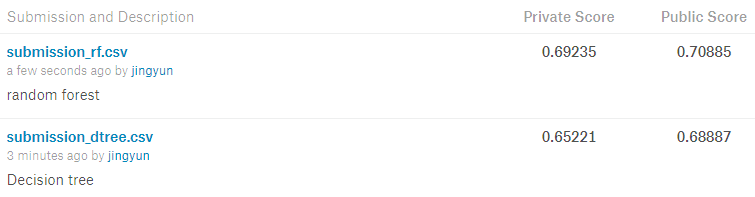

In [46]:
Image(filename= image_path + 'submission_dtree_rf.PNG')

The differences between the kaggle scores and the training scores indicated that our models were overfitted. <p>Therefore, we proceeded to explore more work to better prepare the data for modelling (refer to other notebooks):
1. Regression to predict number of mosquitos - The number of mosquitos was not provided in the kaggle test set and was not considered in the previous model. We will predict the number of mosquitos first before predicting the probability of virus. 
2. Oversampling via SMOTE

Random Forest Classification was used in the exploration as Decision Tree is prone to overfitting.